In a new python environment with python>=3.10

In [83]:
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

  Cloning https://github.com/ENSTA-U2IS-AI/torch-uncertainty (to revision dev) to /tmp/pip-install-1uivnpb6/torch-uncertainty_083ef260340a4b72adeb7c5c26921d2d
  Running command git clone --filter=blob:none --quiet https://github.com/ENSTA-U2IS-AI/torch-uncertainty /tmp/pip-install-1uivnpb6/torch-uncertainty_083ef260340a4b72adeb7c5c26921d2d
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  branch 'dev' set up to track 'origin/dev'.
  Resolved https://github.com/ENSTA-U2IS-AI/torch-uncertainty to commit 179fa3740e3f900800424891b40033a579ee6fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [84]:
# here are the training parameters
batch_size = 10
learning_rate =1e-3
weight_decay=2e-4
lr_decay_epochs=20
lr_decay=0.1
nb_epochs=50
# Skip training and load model locally.
# If never trained, set to False to train and save the model first.
skip_training = True # True to skip

In [85]:
import torch
import numpy as np
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [86]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

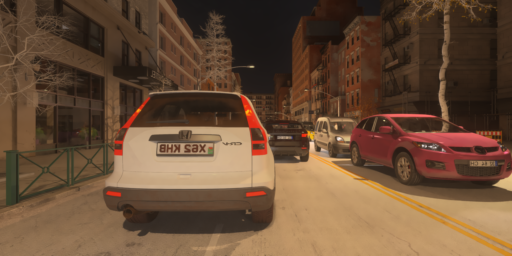

In [87]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

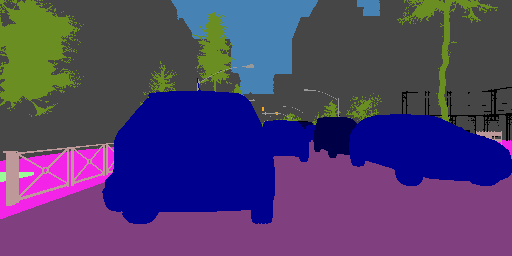

In [88]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [89]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

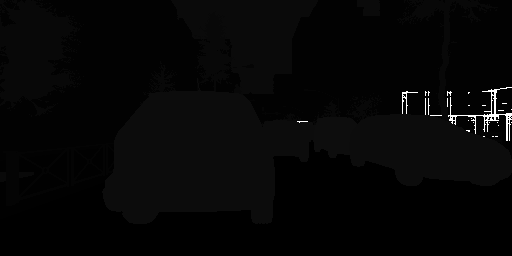

In [90]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [91]:
im.size
print(np.array(im))

[[8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

A: The most part of the image is dark because the value of each pixel (elements in the printed array, e.g., 2, 8, 0, and so on) represents the class ID as the table shown before. Since the pixel range is $[0,255]$ where 0 represents black and 255 represents white, we see most part of the image is black with the fact that most items are recognized by the model, while some of them are not and labeled with class ID 255, being white in the image.

**Q3/ please study the dataset a bit. What it is about?**

A3: MUAD is a uncertainty benchmark dataset for various tasks in autonomous driving. According to the configuration, we are now using the small version of MUAD, with a target of semantics (instead of depth). The corresponding ground truth information each sample in the dataset includes mainly semantic segmentation and the depth map, and the configuration shows our goal of semantic segmentation.

In [92]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)


In [93]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [94]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444,  5.2256, 21.1894, 50.4983, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


**Q4/ why do we need to evaluate the class_weights?**

A4: The sample number of each class is different (i.e., the dataset itself is not balanced). This means potential big differences among the weights of classes, which leads to the case that the model is biased to the majority classes with many samples in the dataset and ignore the minority. We introduce a custom class weighing scheme from ENet to restrict the weights in a certain range, so as for weighting the loss function during training to signal to the model that it should pay greater attention to samples from minority classes.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**

A5: Yes, but a little bit different from the original Unet. There are no dropout layers in the decoder part of the original one. You insert dropout layers for uncertainty evaluation.



**Q6/Do we need a backbone with Unet?**

A6: No, we don't, at least not necessary. The Unet is a complete encoder-decoder architecture which can complete the end-to-end problem, i.e., takes as input the images and outputs the segmentation map. Though we can load pretrained networks like resnets as the backbone, or encoder, to enhance the performance, that is not necessary.




In [95]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [96]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**

A7: IoU, Intersection over Union, is defined as:
$$

IoU = \frac{\text{area of overlap}}{\text{area of union}}

$$
This is a metric to evaluate the accuracy of the model, which preliminarily satisfies the requirement for calculating the geometric similarity between two images, providing a straightforward implementation of image overlap measurement. However, it fails to account for the distance between the two shapes or the similarity in their aspect ratios.


### Training function

**Q8/Please complete the training and the test function**

In [97]:
from torchmetrics.utilities.compute import _safe_divide


def train( model, data_loader, optim, criterion, metric,iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        # Squeeze the channel dimension if present: [B, 1, H, W] -> [B, H, W]
        if labels.ndim == 4 and labels.shape[1] == 1:
            labels = labels.squeeze(1)
        # Forward propagation
        outputs = model(img)
        
        # Loss computation
        loss = criterion(outputs, labels)

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()


        # Flatten the outputs and labels for metric computation
        flatten_logits = rearrange(outputs, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        
        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

### Validation function

In [98]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        # Squeeze the channel dimension if present: [B, 1, H, W] -> [B, H, W]
        if labels.ndim == 4 and labels.shape[1] == 1:
            labels = labels.squeeze(1)
        with torch.no_grad():
            # Forward propagation
            outputs = model(img)
            
            # Flatten the outputs and labels for metric computation
            flatten_logits = rearrange(outputs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(outputs, labels)

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ please train your DNN and comment?**



In [99]:
from torch import optim
from torch.optim import lr_scheduler

from torch_uncertainty.metrics.segmentation import MeanIntersectionOverUnion

print("\nTraining...\n")
num_classes = 19
# Intialize UNet
model = UNet(num_classes)
model = model.cuda()

# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion  combines LogSoftMax and NLLLoss.
criterion = torch.nn.CrossEntropyLoss(weight=class_weights,ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nb_epochs)
print("\nRe-computing class weights for 19 classes...")
full_weights = enet_weighing(train_loader, 21) 
class_weights = torch.from_numpy(full_weights[:19]).float().cuda() # 只取前19个

print("Class weights shape:", class_weights.shape)
print("Class weights:", class_weights)


Training...


Re-computing class weights for 19 classes...


Class weights shape: torch.Size([19])
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444,  5.2256, 21.1894, 50.4983, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


Using device: cuda
Epoch 1/50
  Train Loss: 2.3253 | Train mIoU: 0.0938
  Test Loss:  2.1143 | Test mIoU:  0.1606
  -> Best model saved!
Epoch 2/50
  Train Loss: 1.7888 | Train mIoU: 0.1961
  Test Loss:  1.6418 | Test mIoU:  0.2197
  -> Best model saved!
Epoch 3/50
  Train Loss: 1.4866 | Train mIoU: 0.2330
  Test Loss:  1.5390 | Test mIoU:  0.2420
  -> Best model saved!
Epoch 4/50
  Train Loss: 1.3157 | Train mIoU: 0.2604
  Test Loss:  1.3238 | Test mIoU:  0.2699
  -> Best model saved!
Epoch 5/50
  Train Loss: 1.2022 | Train mIoU: 0.2754
  Test Loss:  1.1685 | Test mIoU:  0.2898
  -> Best model saved!
Epoch 6/50
  Train Loss: 1.1456 | Train mIoU: 0.2808
  Test Loss:  1.0766 | Test mIoU:  0.3277
  -> Best model saved!
Epoch 7/50
  Train Loss: 1.0657 | Train mIoU: 0.2989
  Test Loss:  1.1575 | Test mIoU:  0.2739
Epoch 8/50
  Train Loss: 1.0092 | Train mIoU: 0.3107
  Test Loss:  0.9539 | Test mIoU:  0.3302
  -> Best model saved!
Epoch 9/50
  Train Loss: 0.9593 | Train mIoU: 0.3244
  Test 

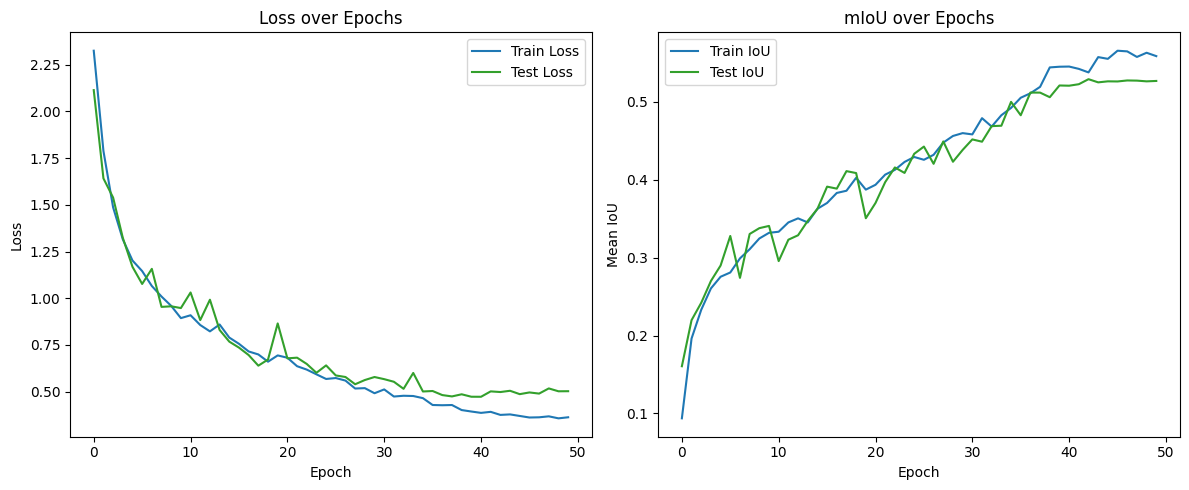

In [100]:
# Start Training
# Training loop
train_losses = []
train_IoU = []
test_losses = []
test_IoU = []

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

best_iou = 0.0
# Initialize metric objects globally for the loop (optional, but cleaner if reset inside)
metric_train_obj = MeanIntersectionOverUnion(num_classes=num_classes).to(device)
metric_test_obj = MeanIntersectionOverUnion(num_classes=num_classes).to(device)

for epoch in range(nb_epochs):
    print(f"Epoch {epoch+1}/{nb_epochs}")
    
    # Train and Validate
    # Note: train/test functions return (loss, per_class_iou, mean_iou) based on your implementation
    train_loss, IoU_per_class_train, _ = train(model, train_loader, optimizer, criterion, metric_train_obj)
    test_loss, IoU_per_class_test, _ = test(model, test_loader, criterion, metric_test_obj)
    
    # Scheduler step
    scheduler.step()
    
    # Record history
    train_losses.append(train_loss)
    # Calculate mean of per-class IoU manually or use the 3rd return value from your function
    train_IoU.append(IoU_per_class_train.nanmean().item()) 
    
    test_losses.append(test_loss)
    test_miou = IoU_per_class_test.nanmean().item()
    test_IoU.append(test_miou)
    
    print(f"  Train Loss: {train_loss:.4f} | Train mIoU: {train_IoU[-1]:.4f}")
    print(f"  Test Loss:  {test_loss:.4f} | Test mIoU:  {test_miou:.4f}")

    # Save best model logic
    if test_miou > best_iou:
        best_iou = test_miou
        torch.save(model.state_dict(), 'unet_best.pth')
        print("  -> Best model saved!")

# Save final model as well
torch.save(model.state_dict(), 'unet.pth')

# Plotting ONCE at the end
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color=colors[0])
plt.plot(test_losses, label='Test Loss', color=colors[1])
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_IoU, label='Train IoU', color=colors[0])
plt.plot(test_IoU, label='Test IoU', color=colors[1])
plt.title('mIoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves_unet.png", dpi=200, bbox_inches="tight")
plt.show()

Load a model

In [101]:
#Loading a model
model = UNet(19)
model.load_state_dict(torch.load("unet.pth"))
model = model.to("cuda")

# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**
Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a definite overfitting to the training dataset.

A10: The curve is similar to the description, we note that the model is potentially overfitting.

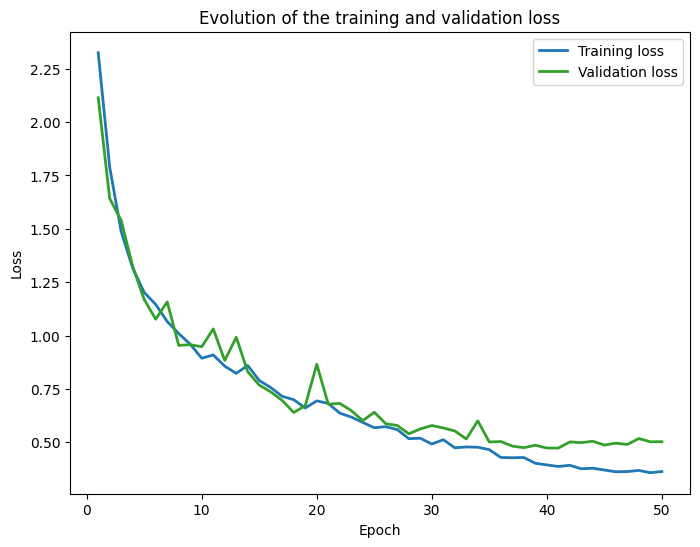

In [102]:
plot_losses(train_losses, test_losses)

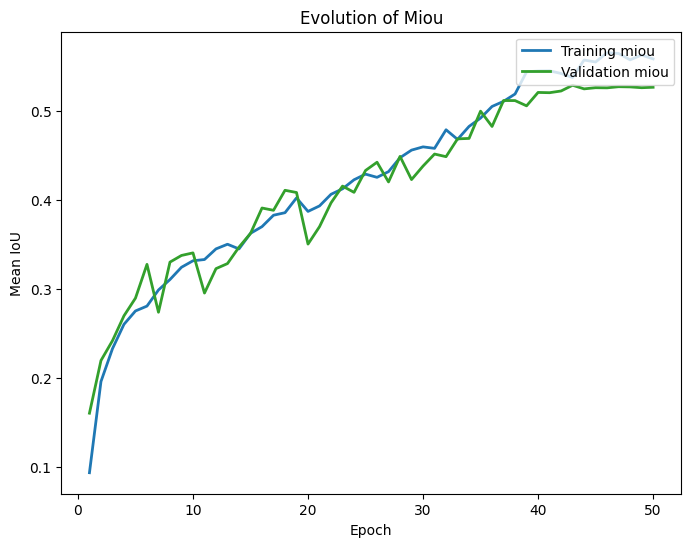

In [103]:
plot_accu(train_IoU, test_IoU)

**Q11/ what should we have done to avoid overfitting?**

A11: We have introduced dropout layers in the decoder part of Unet. To further avoid overfitting, we can:

1. Increase the dropout values (e.g., 0.2 to 0.3)
2. Augment the dataset with random erasing, cropping, erasing, and so on, in order to force the model to learn local features of an image.
3. Use an optimizer with weight decay.

In [104]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric_test_obj)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)
class_names = [c.name for c in test_set.classes if c.id < 19]
# Print per class IoU on last epoch or if best iou
for key, class_iou in zip(class_names, iou, strict=True):
  print(f"{key}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.5025151198108991  | Mean IoU:  tensor(0.5265, device='cuda:0')
road: 0.9514
sidewalk: 0.7519
building: 0.8238
wall: 0.5907
fence: 0.4753
pole: 0.2953
traffic_light: 0.1997
traffic_sign: 0.0459
vegetation: 0.6209
terrain: 0.0021
sky: 0.9223
person: 0.4723
car: 0.7823
truck: 0.4374
bus: nan
rider: nan
train: nan
motorcycle: nan
bicycle: nan


## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [105]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

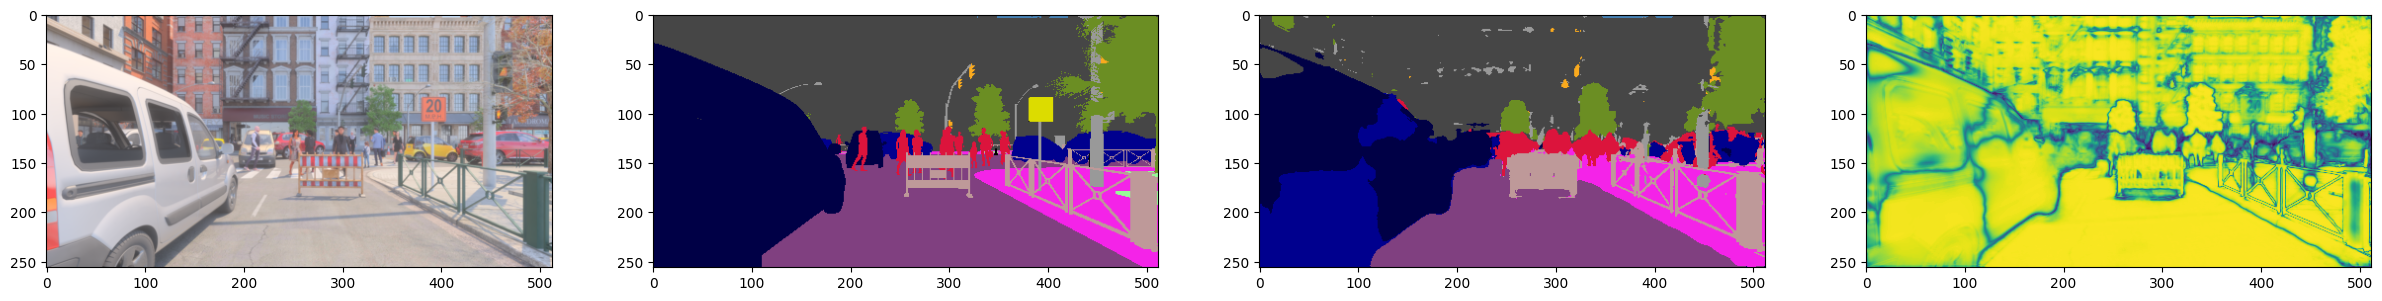

In [106]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**

Because the image visualizes the maximum class probability, a proxy for the model's confidence. Bright and yellow areas represent high confidence, meaning that the model is confident that its prediction in these areas. The dark areas represent low confidence, and the model represents uncertainty here.

### Now let's load the OOD test set

In [107]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

ood.zip:   0%|          | 0.00/193M [00:00<?, ?B/s]

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [108]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

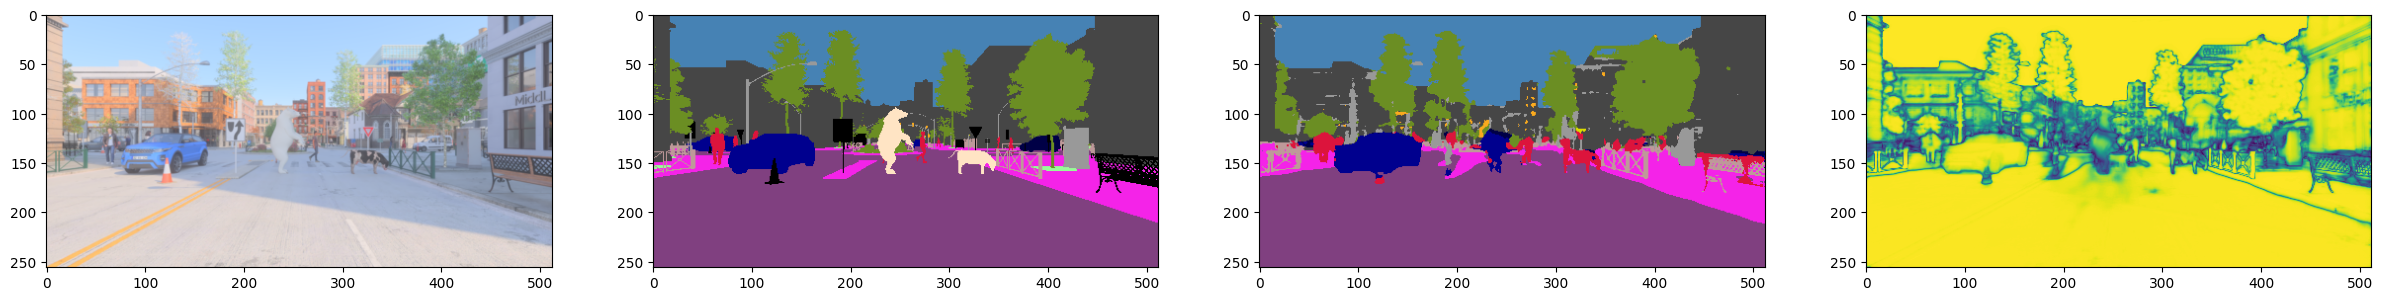

In [109]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**

A: The model is over-confident when it comes to labeling the bear, the goat, and the bench. We train the model under the case that we ignore classes with ID greater than 19, such that those classes can be used as OOD objects. In the last image, the areas corresponding to the bear and the goat, and the bench are darker than the surrounding yellow marked items that the model is confident about, but not dark enough. They are still quite bright, i.e., the model is over-confident about these OOD objects, though the model doesn't know what they are. This means the model incorrectly classifies them as something In-Distribution. In specific, the bear in the 3rd image is marked in blue, which means it is classified as a car, and similarly the goat is classified as a pedestrian, the bench is divided into several parts corresponding to sidewalk, fence, and pedestrian.


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**

Because the image visualizes the maximum class probability, a proxy for the model's confidence. As we mentioned before, bright and yellow areas represent high confidence, meaning that the model is confident that its prediction in these areas. The dark areas represent low confidence, and the model represents uncertainty here.

We are not happy with this image, because the model is over-confident and tends to classify OOD objects as ID objects. Ideally, for those OOD objects, corresponding areas in the confidence map should be dark or blue, however, the fact that it is bright yellow indicates that the model is poorly calibrated and fails to flag these anomalies as unknown.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

In [110]:
from torch_uncertainty.metrics import CalibrationError



**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

After temperature scaling

In [111]:
from torch_uncertainty.post_processing import TemperatureScaler



Now let's see the new confidence score image after scaling

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

In [112]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout


**Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [113]:
from torch_uncertainty.models import deep_ensembles

Test your ensemble obtained either using option 1 or 2.

In [114]:
results = trainer.test(ens_routine, test_loader)

NameError: name 'trainer' is not defined

Save the ensemble model

In [ ]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth


## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/alafage/miniconda3/envs/test_tp/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alafage/thesis/torch-uncertainty/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | model                   | PackedUNet       | 2.1 M  | train
1 | loss                    | CrossEntropyLoss | 0      | train
2 | format_batch_fn         | RepeatTarget     | 0      | train
3 | val_seg_metrics         | MetricCollection | 0      | train
4 | val_sbsmpl_seg_metrics  | MetricCollection | 0      | train
5 | test_seg_metrics        | MetricCollection | 0      | train
6 | test_sbsmpl_seg_metrics | MetricCollection | 0      | train
---------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total pa

Epoch 49: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃       Segmentation        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Brier     │          0.41144          │
│     NLL      │          0.88911          │
│     mAcc     │          50.58%           │
│     mIoU     │          37.54%           │
│    pixAcc    │          78.32%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.27004          │
│     aECE     │          0.27004          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │           5.81%           │
│     AURC     │           7.96%           │
└──────────────┴───────────────────────────┘

**Please conclude your report**